# Completion Trie and metrics

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Wikipedia titles, uniform

In [ ]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3049881,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ["Festival d'Angouleme 1982",
  "Festival d'Angouleme 1983",
  "Festival d'Angouleme 1984",
  "Festival d'Angouleme 1985",
  "Festival d'Angouleme 1986"])

In [ ]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(w * len(q) for q, w in zip(queries, weights))
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w)-trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w)-trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w)-trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum( g*p/total for w, p, g in wks)
    gain_dyn = sum( g*p/total for w, p, g in wks_dyn)
    gain_dyn2 = sum( g*p/total for w, p, g in wks_dyn2)
    ave_length = sum( len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [ ]:
import time, random, pandas

def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.clock()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.3001885439353554s - nb=200 gain (0.8252032520325199, 0.8252032520325199, 0.8252032520325199, 1.0)
time: 0.6137829935850588s - nb=500 gain (0.7973762426975491, 0.7973762426975491, 0.7973762426975491, 1.0)
time: 0.9145338765428509s - nb=800 gain (0.7820163487738426, 0.7820163487738426, 0.7820163487738426, 1.0)
time: 1.1865045476762996s - nb=1000 gain (0.7720932653273656, 0.7720932653273656, 0.7720932653273656, 1.0)
time: 2.55021088782427s - nb=2000 gain (0.7490387884811539, 0.7490387884811539, 0.7490387884811539, 1.0)
time: 6.142421444659639s - nb=5000 gain (0.7160502627184325, 0.7160502627184325, 0.7160502627184325, 1.0)
time: 10.071600083303151s - nb=8000 gain (0.6997310682883094, 0.6997310682883094, 0.6997310682883094, 1.0)
time: 13.640646548756507s - nb=10000 gain (0.6859118605057526, 0.6859169980374769, 0.6859169980374769, 1.0)
time: 23.729151013471764s - nb=20000 gain (0.6591407171005124, 0.659184190135723, 0.659184190135723, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,13.640647,0.685912,0.685917,0.685917,1.0,0.685912,1.0,0.685917,1.000007,0.685917,1.000007
8,20000,23.729151,0.659141,0.659184,0.659184,1.0,0.659141,1.0,0.659184,1.000066,0.659184,1.000066


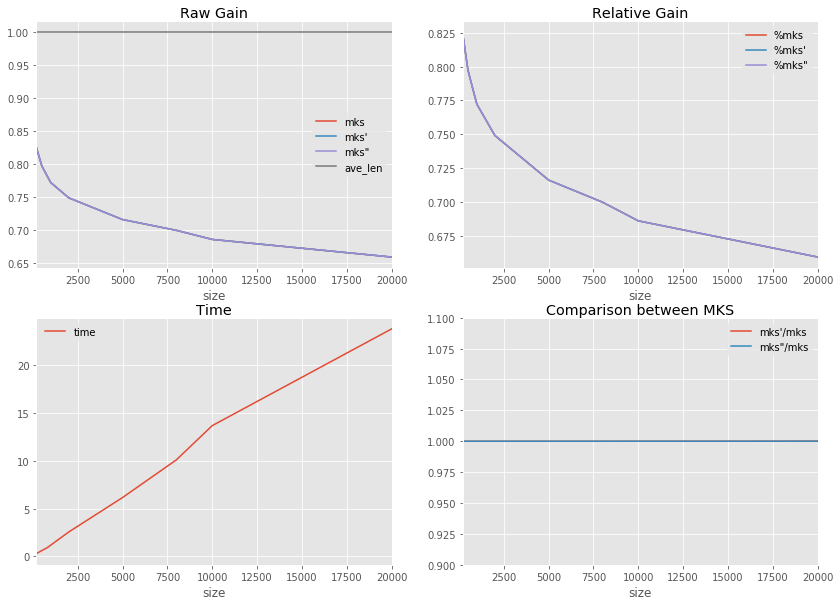

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Reduce the alphabet size

In [ ]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(set(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z')))

In [ ]:
import time, random, pandas

def char_modulo(c, size):
    if len(c) != 1:
        raise Exception("unexpected size '%s'" % c)
    if len(c) != len(c.lower()):
        raise Exception("unexpected lower size '%s' != '%s' (%d != %d)" % (c, c.lower(), len(c), len(c.lower())))
    if size is None:
        return c
    else:
        o = ord(c.lower())
        a = 97
        d = (o - a) + size * 10
        return chr(97  + (d % size))

def reduce_alphabet(sample, size):
    return ["".join(char_modulo(c, size) for c in word) for word in sample]

def benchmark_size(size, alphabet_sizes):
    if size is None:
        size = len(list_titles)
        sample = list_titles
    else:
        sample = random.sample(list_titles, size)
    print("time", 0)
    allres = []
    for size in alphabet_sizes:
        begin = time.clock()
        spl = reduce_alphabet(sample, size)
        spl = list(sorted(set(spl)))
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        if size is None:
            size = max(_ for _ in alphabet_sizes if _ is not None) + 5
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark_size(5000, [None] + list(range(2, 26)))
df.tail(n=2)

time 0
time: 7.287039218763567s - nb=5000 gain (0.7173810645313308, 0.7173810645313308, 0.7173810645313308, 1.0)
time: 4.2320933508435274s - nb=4560 gain (0.42023531905871964, 0.44002543989823545, 0.44002543989823545, 1.0)
time: 5.293620509680139s - nb=4940 gain (0.5598274356735627, 0.5630938318524954, 0.5630938318524954, 1.0)
time: 5.764394489163109s - nb=4970 gain (0.5999302657081574, 0.6058576805143888, 0.6058576805143888, 1.0)
time: 5.88490138968298s - nb=4998 gain (0.6383745698836594, 0.6399721448467924, 0.6399721448467924, 1.0)
time: 5.695775016496s - nb=4994 gain (0.6494049204170752, 0.6502038224389117, 0.6502038224389117, 1.0)
time: 6.7235387417375705s - nb=4997 gain (0.6662945628462889, 0.6681072887969461, 0.6681072887969461, 1.0)
time: 6.172068898717825s - nb=5000 gain (0.6722644330213635, 0.6722644330213635, 0.6722644330213635, 1.0)
time: 6.273765452028641s - nb=5000 gain (0.6851973212640052, 0.6851973212640052, 0.6851973212640052, 1.0)
time: 8.12473834130087s - nb=5000 gain

,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
23,24,6.430348,0.713439,0.713439,0.713439,1.0,0.713439,1.0,0.713439,1.000000,0.713439,1.000000
24,25,6.689720,0.714811,0.714842,0.714842,1.0,0.714811,1.0,0.714842,1.000043,0.714842,1.000043


In [ ]:
df = df.sort_values("size")

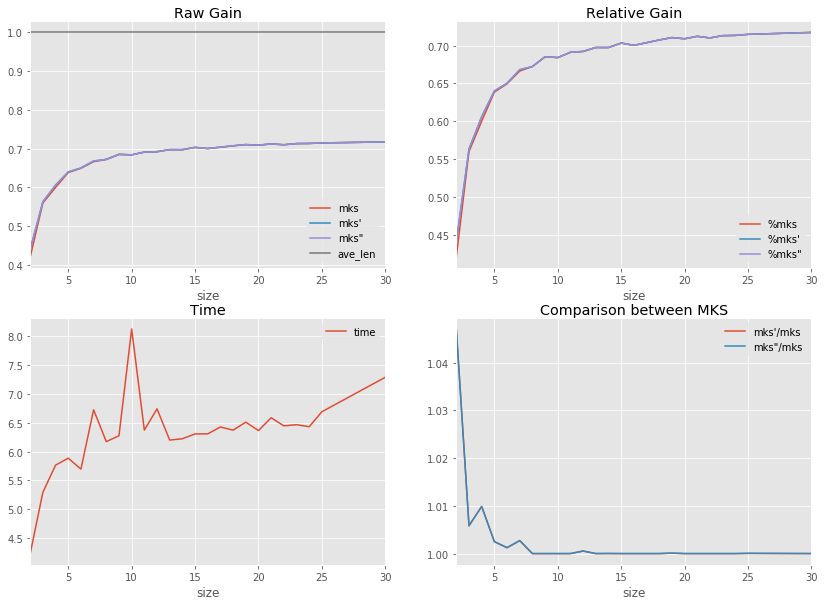

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df.plot(x="size", y="time", ax=ax[1,0])
df.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
#ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [ ]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 53.018289488707666s - nb=50000 gain (0.6163220367718374, 0.616418041543479, 0.616418041543479, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,53.018289,0.616322,0.616418,0.616418,1.0,0.616322,1.0,0.616418,1.000156,0.616418,1.000156


In [ ]:
df2 = benchmark([50000, 100000, 200000]) # , 500000, 500000, 1000000, 2000000, None]) too long in python
df2.tail(n=2)

time 0
time: 61.65742135699463s - nb=50000 gain (0.6169895343292132, 0.6172917919691325, 0.6172917919691325, 1.0)
time: 114.09209830284806s - nb=100000 gain (0.5836512803377542, 0.5839556895046727, 0.5839556895046727, 1.0)
time: 218.2331598706321s - nb=200000 gain (0.549484754820996, 0.550236084638899, 0.550236084638899, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
1,100000,114.092098,0.583651,0.583956,0.583956,1.0,0.583651,1.0,0.583956,1.000522,0.583956,1.000522
2,200000,218.233160,0.549485,0.550236,0.550236,1.0,0.549485,1.0,0.550236,1.001367,0.550236,1.001367


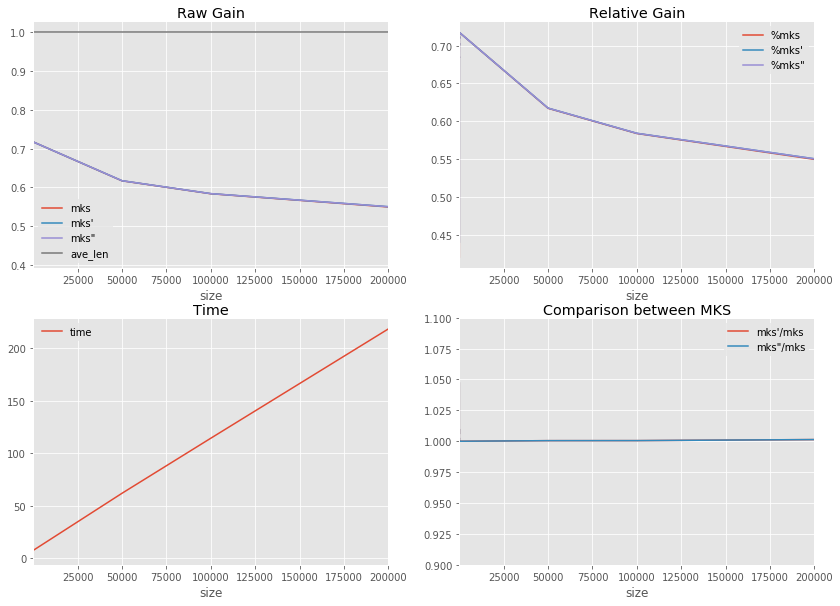

In [ ]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14,10))
dfall.plot(x="size", y="time", ax=ax[1,0])
dfall.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
dfall.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
dfall.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")